In [2]:
from google.colab import drive
import os
import glob
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dir_path = '/content/drive/MyDrive/CXR_data'
disease_cls = ['effusion', 'nofinding']

# !unzip '/content/drive/MyDrive/CXR_data_UpGrad.zip' -d '/content/drive/MyDrive/CXR_data'

## Data visualization

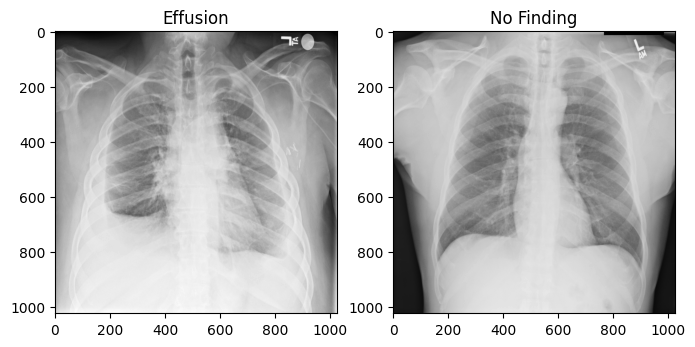

In [7]:
effusion_path = os.path.join(dir_path, disease_cls[0], '*')
effusion_imgs = glob.glob(effusion_path)
effusion = io.imread(effusion_imgs[0])

nofinding_path = os.path.join(dir_path, disease_cls[1], '*')
nofinding_imgs = glob.glob(nofinding_path)
nofinding = io.imread(nofinding_imgs[0])

f, axes = plt.subplots(1, 2, figsize=(8, 5))
axes[0].imshow(effusion, cmap='gray')
axes[0].set_title('Effusion')
axes[1].imshow(nofinding, cmap='gray')
axes[1].set_title('No Finding')

plt.show()

In [ ]:
effusion.shape

(1024, 1024)

In [8]:
nofinding.shape

(1024, 1024)

## Data augmentation

In [5]:
from skimage.transform import rescale
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0,
    height_shift_range=0,
    vertical_flip=False,)

def preprocess_img(img, mode):
    img = (img - img.min())/(img.max() - img.min())
    img = rescale(img, 0.25, mode='constant')
    if mode == 'train':
        if np.random.randn() > 0:
            img = datagen.random_transform(img)
    return img

## Model building

In [6]:
from google.colab import files
src = list(files.upload().values())[0]
open('resnet.py','wb').write(src)

Saving resnet.py to resnet.py


9192

In [7]:
import resnet

img_channels = 1
img_rows = 256
img_cols = 256

nb_classes = 2

In [8]:
import numpy as np
import tensorflow as tf

class AugmentedDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = ['nofinding', 'effusion'],
                 batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode

        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(dir_path, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:ablation]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})


        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = io.imread(ID)
            img = img[:, :, np.newaxis]
            if img.shape == (1024, 1024,1):
                img = preprocess_img(img, self.mode)
                X[i,] = img
                y[i] = self.labels[ID]
            else:
                delete_rows.append(i)
                continue

        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)

        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

## Ablation run

In [9]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD

In [14]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss=categorical_crossentropy, optimizer=SGD(), metrics=['accuracy'])

train_ds = AugmentedDataGenerator(mode='train', ablation=100)
test_ds = AugmentedDataGenerator(mode='test', ablation=100)

model.fit(train_ds, epochs=1, validation_data=test_ds)

5/5 [==============================] - 72s 15s/step - loss: 1.6977 - accuracy: 0.4710 - val_loss: 2.0497 - val_accuracy: 0.1875


## Class distribution

In [16]:
effusion_class_len = len(glob.glob(effusion_path))
nofinding_class_len = len(glob.glob(nofinding_path))

In [17]:
print('Images in Effusion class:', effusion_class_len)
print('Images in Nofinding class:', nofinding_class_len)

Images in Effusion class: 107
Images in Nofinding class: 1000


## Handling class imbalance

To handle the class imbalance we penalise more to each misclassification by a model. To do this we define a custom loss function `w_categorical_crossentropy`

In [10]:
from functools import partial
import tensorflow.keras.backend as K
from itertools import product

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    cross_ent = K.categorical_crossentropy(y_true, y_pred, from_logits=False)
    return cross_ent * final_mask

bin_weights = np.ones((2,2))
bin_weights[0, 1] = 5
bin_weights[1, 0] = 5
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

In [11]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss=ncce, optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=100)
validation_generator = AugmentedDataGenerator('val', ablation=100)

model.fit(training_generator, epochs=1, validation_data=None)

5/5 [==============================] - 41s 7s/step - loss: 4.7237 - accuracy: 0.5130


## Define few call backs

In [12]:
# LR decay

class DecayLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch
        self.lr_history = []

    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [13]:
# Auc logger

from sklearn.metrics import roc_auc_score
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

class roc_callback(Callback):

    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

## Final run

In [15]:
from keras.callbacks import ModelCheckpoint

model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
sgd = optimizers.SGD(lr=0.005)

bin_weights = np.ones((2,2))
bin_weights[1, 1] = 10
bin_weights[1, 0] = 10
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

model.compile(loss=ncce,optimizer= sgd,
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train')
validation_generator = AugmentedDataGenerator('val')

auc_logger = roc_callback()
filepath = 'models/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

decay = DecayLR()

model.fit(training_generator, epochs=15, validation_data=validation_generator, callbacks=[auc_logger, decay, checkpoint])

Epoch 1/15
1/1 [==============================] - 0s 198ms/step

Val AUC for epoch0: 0.5299418604651163

Epoch 1: val_auc improved from -inf to 0.52994, saving model to models/best_model.hdf5
27/27 [==============================] - 93s 3s/step - loss: 2.2453 - accuracy: 0.5341 - val_loss: 2.4882 - val_accuracy: 0.8750 - val_auc: 0.5299
Epoch 2/15
1/1 [==============================] - 0s 194ms/step

Val AUC for epoch1: 0.5672316384180791

Epoch 2: val_auc improved from 0.52994 to 0.56723, saving model to models/best_model.hdf5
27/27 [==============================] - 78s 3s/step - loss: 2.1482 - accuracy: 0.6251 - val_loss: 3.0245 - val_accuracy: 0.1042 - val_auc: 0.5672
Epoch 3/15
1/1 [==============================] - 0s 234ms/step

Val AUC for epoch2: 0.6104725415070242

Epoch 3: val_auc improved from 0.56723 to 0.61047, saving model to models/best_model.hdf5
27/27 [==============================] - 78s 3s/step - loss: 2.0656 - accuracy: 0.6587 - val_loss: 2.7170 - val_accuracy: 0.

## Making predictions

In [16]:
val_model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
val_model.load_weights('models/best_model.hdf5')

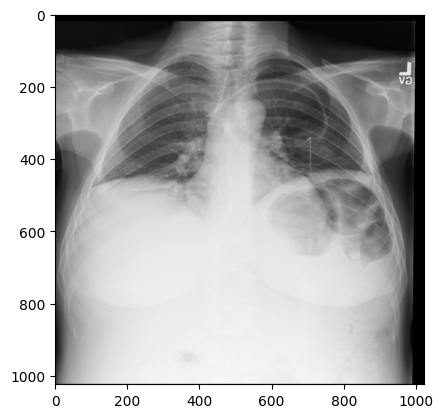

In [20]:
effusion_path = os.path.join(dir_path, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[-7])
plt.imshow(effusion,cmap='gray')

In [21]:
img = preprocess_img(effusion[:, :, np.newaxis], 'validation')
val_model.predict(img[np.newaxis,:])

1/1 [==============================] - 0s 51ms/step


array([[0.1823363 , 0.81766367]], dtype=float32)

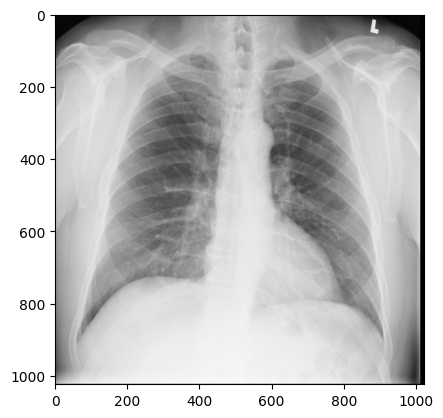

In [44]:
normal_path = os.path.join(dir_path, disease_cls[1], '*')
normal = glob.glob(normal_path)
normal = io.imread(normal[-11])
plt.imshow(normal,cmap='gray')

In [45]:
img = preprocess_img(normal[:, :, np.newaxis], 'validation')
val_model.predict(img[np.newaxis,:])

1/1 [==============================] - 0s 48ms/step


array([[0.48995522, 0.5100448 ]], dtype=float32)